# Setup

## import libraries and packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import cv2
import numpy as np
from random import shuffle
from keras.utils import np_utils
from pathlib import Path
from typing import Union
from multiprocessing import Pool
import keras
import pandas as pd
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## setup constants

In [2]:
TRAIN = Path('data/dataset5/A')
TEST = Path('data/dataset5/E')
RESIZED_TRAIN = Path('data/dataset5')
RESIZED_TEST = Path('data/dataset5_resized')
RESIZED_NPY = Path('data/dataset5_npy')
NEW_SIZE = (224,224)
MODEL = Path('/home/yoav/PycharmProjects/ITC/hackathon/Team10/model2.json')
MODEL_WEIGHTS = Path('/home/yoav/PycharmProjects/ITC/hackathon/Team10/weights2.h5')
RANDOM_STATE = 42
VALIDATION_SIZE = 0.2
os.makedirs(RESIZED_NPY, exist_ok=True)

## generate output paths

In [3]:
os.makedirs(RESIZED_TRAIN, exist_ok=True)
os.makedirs(RESIZED_TEST, exist_ok=True)
os.makedirs(RESIZED_NPY, exist_ok=True)

## helper functions

In [4]:
def sub_dirs(directory: Path):
    sub_lst = []
    for sub_dir in directory.glob('*'):
        if sub_dir.is_dir():
            sub_lst.append(sub_dir)
    return sub_lst

def resize_img(img: Union[str, Path], new_img: Union[str, Path], 
               new_size=(224,224)):
    image = cv2.imread(str(img))
    resized_image = cv2.resize(image,new_size)
    cv2.imwrite(str(new_img), resized_image)
    
def make_pool(input_dirs: list, output_dir: Path, new_size: tuple, suffix: str = '*.jpg') -> list:
    features, labels, pool_jobs = [], [], []
    for input_sub in sub_dirs(input_dirs):
        if not input_sub.is_dir(): continue
        set_group = input_sub.name
        output_sub = output_dir / set_group
        for label in input_sub.glob('*'):
            if not label.is_dir(): continue
            output_label = output_sub / label.name
            os.makedirs(output_label, exist_ok=True)
            for img in label.glob(suffix):
                new_img = output_label / img.name
                pool_jobs.append((img, new_img, new_size))
                features.append(str(new_img)), labels.append(label.name)
    return features, labels, pool_jobs


def scale_pool(img_lst, by: int = 255):
    return [(img, by) for img in img_lst]
    
def scale(img_dir: np.array, by: int = 255):
    return cv2.imread(str(img_dir))/255

# preprocessing

## creating resize image jobs

In [5]:
X, y, pool = make_pool(Path('data/dataset5'), Path('data/dataset5_resized'), NEW_SIZE, suffix='*.png')

## execute image resize

In [6]:
with Pool() as p: p.starmap(resize_img, pool)

## split train, test and validation sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

## convert 2 one hot encoding

In [8]:
label_lst = pd.get_dummies(y_train).columns.tolist()
y_train_cat = pd.get_dummies(y_train).values
y_val_cat = pd.get_dummies(y_val).values
y_test_cat = pd.get_dummies(y_test).values

## read images to np.array and scale

In [9]:
X_train = np.array([cv2.imread(str(img)) for img in X_train])
X_val = np.array([cv2.imread(str(img)) for img in X_val])
X_test = np.array([cv2.imread(str(img)) for img in X_test])

## save numpy object to disk

In [10]:
np.save(str(RESIZED_NPY/'X_train.npy'), X_train)
np.save(str(RESIZED_NPY/'X_val.npy'), X_val)
np.save(str(RESIZED_NPY/'X_test.npy'), X_test)
np.save(str(RESIZED_NPY/'y_train.npy'), y_train_cat)
np.save(str(RESIZED_NPY/'y_val.npy'), y_val_cat)
np.save(str(RESIZED_NPY/'y_test.npy'), y_test_cat)

## load numpy object to disk

In [11]:
X_train=np.load(str(RESIZED_NPY/'X_train.npy'))
Y_train=np.load(str(RESIZED_NPY/'y_train.npy'))
X_val=np.load(str(RESIZED_NPY/'X_val.npy'))
Y_val=np.load(str(RESIZED_NPY/'y_val.npy'))
X_test=np.load(str(RESIZED_NPY/'X_test.npy'))
Y_test=np.load(str(RESIZED_NPY/'y_test.npy'))

# Modeling

## creating a sequential model

In [12]:
model = Sequential()
# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())
# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())
# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())
# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.6))
# Batch Normalisation
model.add(BatchNormalization())
# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())
# Output Layer
model.add(Dense(24))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0

## Compile 

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## some callbacks

In [14]:
checkpoint = ModelCheckpoint("Checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, 
save_best_only=False, save_weights_only=False, mode='auto')
callback = EarlyStopping(monitor='val_loss', patience=5)

# Train

In [15]:
model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1,validation_data=(X_val, Y_val), shuffle=True,callbacks=[callback, checkpoint])

Epoch 1/10
2634/2634 [==============================] - 1488s 565ms/step - loss: 2.6487 - accuracy: 0.2457 - val_loss: 0.9482 - val_accuracy: 0.7019
Epoch 2/10
2634/2634 [==============================] - 1474s 560ms/step - loss: 0.7547 - accuracy: 0.7586 - val_loss: 0.6330 - val_accuracy: 0.8110
Epoch 3/10
2634/2634 [==============================] - 1481s 562ms/step - loss: 0.4142 - accuracy: 0.8734 - val_loss: 0.3464 - val_accuracy: 0.8910
Epoch 4/10
2634/2634 [==============================] - 1503s 571ms/step - loss: 0.2793 - accuracy: 0.9128 - val_loss: 0.2371 - val_accuracy: 0.9263
Epoch 5/10
2634/2634 [==============================] - 1463s 555ms/step - loss: 0.2067 - accuracy: 0.9350 - val_loss: 0.2043 - val_accuracy: 0.9366
Epoch 6/10
2634/2634 [==============================] - 1465s 556ms/step - loss: 0.1672 - accuracy: 0.9485 - val_loss: 0.1669 - val_accuracy: 0.9498
Epoch 7/10
2634/2634 [==============================] - 1454s 552ms/step - loss: 0.1327 - accuracy: 0.9600

# save model and weights to disk

In [16]:
# serialize model to JSON
model_json = model.to_json()
with open(str(MODEL), 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(str(MODEL_WEIGHTS))

# Testing

In [16]:
accu = np.mean(np.argmax(y_test_cat, axis=1) == np.argmax(model.predict(X_test), axis=1))
print('accuracy score over test = {}'.format(np.round(accu, 2)))

accuracy score over test = 0.97


In [76]:
rand_idx = np.random.choice(range(len(X_test)), 4)

In [77]:
X_subset = X_test[rand_idx, :]
y_subset = np.array(y_test)[rand_idx]

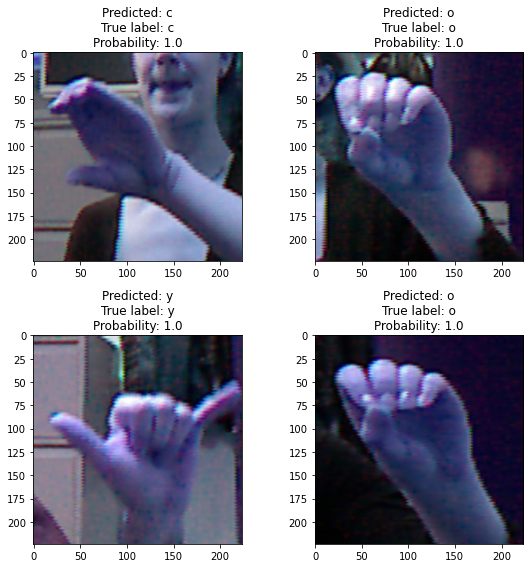

In [145]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for predictor, true_label, ax in zip(X_subset, y_subset, axes.ravel()):
    pred = model.predict(np.expand_dims(predictor, axis=0))
    most_probable_idx = np.argmax(pred[0])
    predicted_label = label_lst[most_probable_idx]
    proba = np.round(pred[0][most_probable_idx], 4)
    title = 'Predicted: {}\nTrue label: {}\nProbability: {}'.format(predicted_label, true_label, proba)
    ax.imshow(predictor)
    ax.set_title(title)
plt.tight_layout()
plt.show()

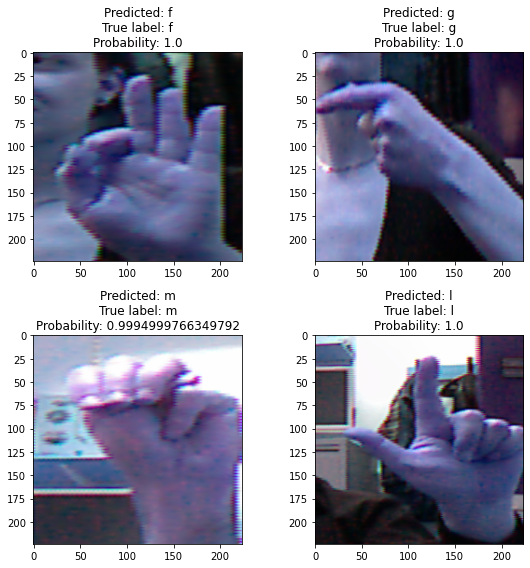

In [166]:
rand_idx = np.random.choice(range(len(X_test)), 4)
X_subset = X_test[rand_idx, :]
y_subset = np.array(y_test)[rand_idx]
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for predictor, true_label, ax in zip(X_subset, y_subset, axes.ravel()):
    pred = model.predict(np.expand_dims(predictor, axis=0))
    most_probable_idx = np.argmax(pred[0])
    predicted_label = label_lst[most_probable_idx]
    proba = np.round(pred[0][most_probable_idx], 4)
    title = 'Predicted: {}\nTrue label: {}\nProbability: {}'.format(predicted_label, true_label, proba)
    ax.imshow(predictor)
    ax.set_title(title)
plt.tight_layout()
plt.show()

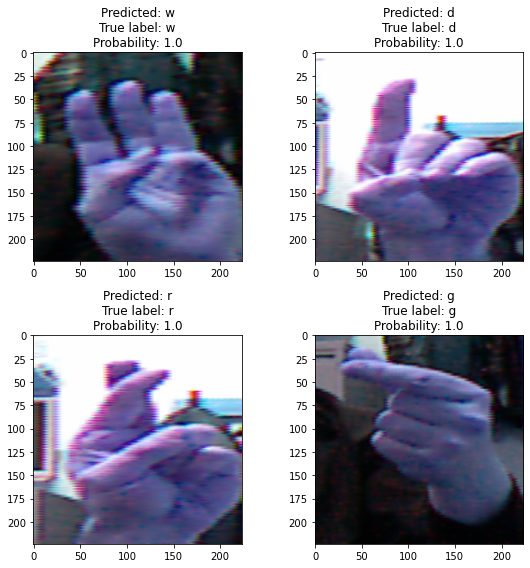

In [170]:
rand_idx = np.random.choice(range(len(X_test)), 4)
X_subset = X_test[rand_idx, :]
y_subset = np.array(y_test)[rand_idx]
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for predictor, true_label, ax in zip(X_subset, y_subset, axes.ravel()):
    pred = model.predict(np.expand_dims(predictor, axis=0))
    most_probable_idx = np.argmax(pred[0])
    predicted_label = label_lst[most_probable_idx]
    proba = np.round(pred[0][most_probable_idx], 4)
    title = 'Predicted: {}\nTrue label: {}\nProbability: {}'.format(predicted_label, true_label, proba)
    ax.imshow(predictor)
    ax.set_title(title)
plt.tight_layout()
plt.show()

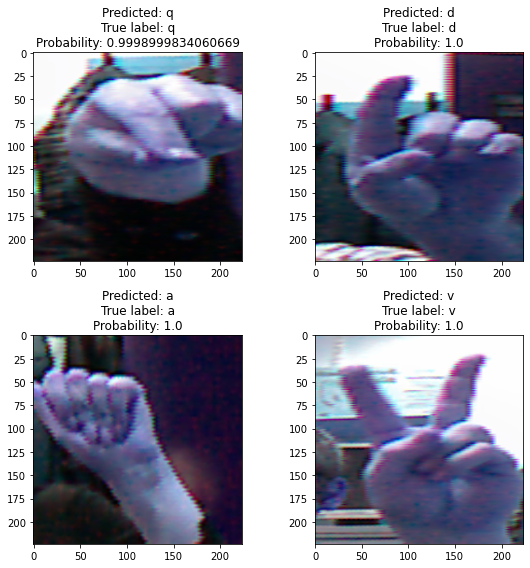

In [174]:
rand_idx = np.random.choice(range(len(X_test)), 4)
X_subset = X_test[rand_idx, :]
y_subset = np.array(y_test)[rand_idx]
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for predictor, true_label, ax in zip(X_subset, y_subset, axes.ravel()):
    pred = model.predict(np.expand_dims(predictor, axis=0))
    most_probable_idx = np.argmax(pred[0])
    predicted_label = label_lst[most_probable_idx]
    proba = np.round(pred[0][most_probable_idx], 4)
    title = 'Predicted: {}\nTrue label: {}\nProbability: {}'.format(predicted_label, true_label, proba)
    ax.imshow(predictor)
    ax.set_title(title)
plt.tight_layout()
plt.show()

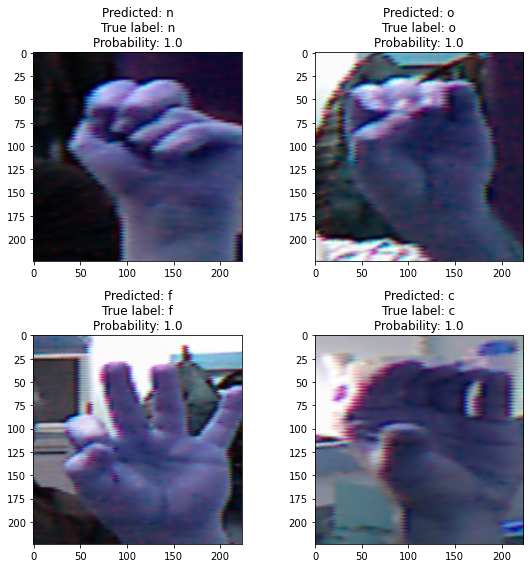

In [182]:
rand_idx = np.random.choice(range(len(X_test)), 4)
X_subset = X_test[rand_idx, :]
y_subset = np.array(y_test)[rand_idx]
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for predictor, true_label, ax in zip(X_subset, y_subset, axes.ravel()):
    pred = model.predict(np.expand_dims(predictor, axis=0))
    most_probable_idx = np.argmax(pred[0])
    predicted_label = label_lst[most_probable_idx]
    proba = np.round(pred[0][most_probable_idx], 4)
    title = 'Predicted: {}\nTrue label: {}\nProbability: {}'.format(predicted_label, true_label, proba)
    ax.imshow(predictor)
    ax.set_title(title)
plt.tight_layout()
plt.show()